## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [29]:
import pickle
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt

# url to get github data
url = "https://raw.githubusercontent.com/KendallFreese/pca_assignment/main/data/all_tokens.pickle"

# open url and perform given actions
with urllib.request.urlopen(url) as response:
    all_tokens = pickle.load(response)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()
token_counts = pd.Series(all_tokens).value_counts()
token_counts.head(20)

,count
new,1365
date,1202
get,1052
please,1022
enron,927
like,923
2002,869
would,806
one,798
message,795


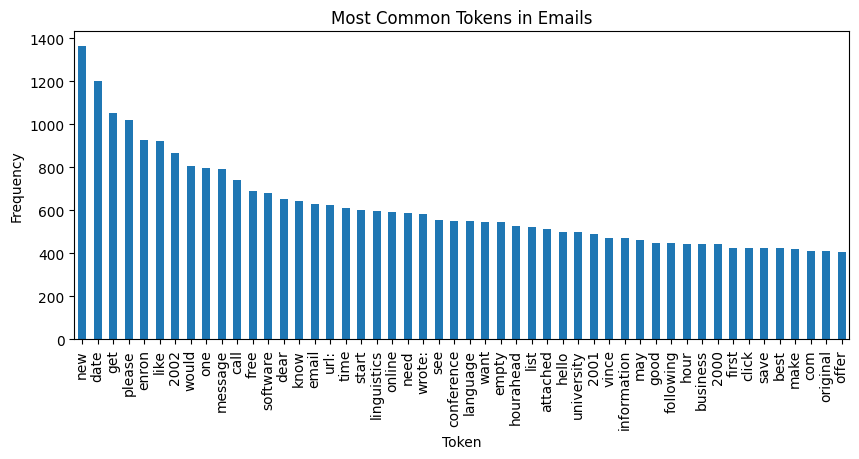

In [30]:
# histogram plot of top 50 tokens

plt.figure(figsize=(10, 4))
token_counts.head(50).plot(kind="bar")
plt.title("Most Common Tokens in Emails")
plt.ylabel("Frequency")
plt.xlabel("Token")
plt.show()

The frequency of occurrence of different tokens shows a strongly right skewed distribution that resembles a long-tail. The histogram shows diminishing returns with the most dramatic drop at the 1st set of frequent tokens and each subsequent additional token with a smaller frequency. The most common word "new" occurs 2x as much as the 12th most frequent "free". We can see that a select few tokens occur very frequently while the majority stabilize at a frequency around 400.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [31]:

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import io

url = "https://raw.githubusercontent.com/KendallFreese/pca_assignment/main/data/Phishing_clean.parquet"

with urllib.request.urlopen(url) as response:
    data = response.read()

phish = pd.read_parquet(io.BytesIO(data))
print(phish.shape)
phish.head()

# separating predictors and response
X = phish.drop("Email Type", axis=1)
y = phish["Email Type"]

# 80/20 train-test split on data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# regression of y on on-hot-encoded email
lm = LinearRegression()
lm.fit(X_train, y_train)

# r-squared on training and test sets
print("Train R-squared:", lm.score(X_train, y_train))
print("Test R-squared: ", lm.score(X_test, y_test))

# words w/ largest coefficients in absolute value
coefs = pd.Series(lm.coef_, index=X.columns)
coefs.abs().sort_values(ascending=False).head(15)

(18634, 2712)
Train R-squared: 0.768699350041784
Test R-squared:  0.6516549296925569


,0
background-image:,1.137598
aging,1.043082
localized,0.777854
"helvetica,",0.660271
reversing,0.580435
thermal,0.565385
shopper,0.532474
xanaax,0.513261
form.,0.509858
burning,0.508505


The words that have the largest coefficients and have the strongtest impact on predictions are background-image and aging which both have coefficients > 1. The next impactful words are localized, helvetica, and reversing. These words appear to ressemble fonts/html words. Some words that may signal phishing include shopper and xanaax which both have somewhat strong coefficients at 0.53 and 0.51 respecitvely.  

### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

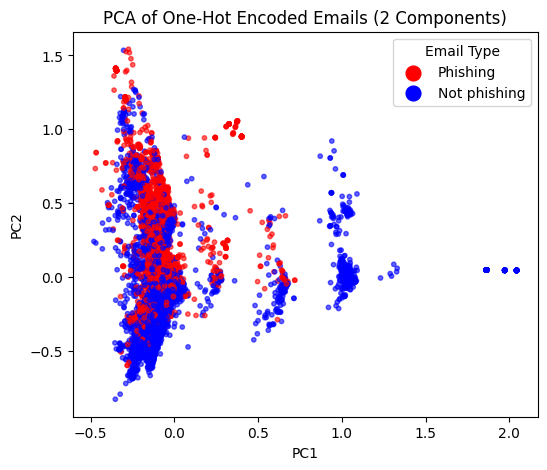

array([0.01113091, 0.00861199])

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# pca analysis decomp
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# scatterplot of first 2 components
plt.figure(figsize=(6, 5))
colors = np.where(y == 1, 'red', 'blue')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=10, alpha=0.6)
plt.scatter([], [], color='red', label='Phishing', s=50)
plt.scatter([], [], color='blue', label='Not phishing', s=50)
plt.title("PCA of One-Hot Encoded Emails (2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Email Type", loc="upper right", markerscale=1.5)
plt.show()

# checking explained variance
pca.explained_variance_ratio_

I notice multiple patterns. I see that the PCA plot shows clustering of phising vs. non-phising emails which shows that token patterns are diverse across 2 groups. The expalined variance ratio of (0.011, 0.009) shows that the 2 components capture only about 1% of total variance, thus the two groups overlap significantly. This shows that to detect phishing, we need more features and more advanced modeling to discern between phishing vs. non-phishing emails.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [33]:
# fitting PCA w/ 2610 components
pca_full = PCA(n_components=2610)
X_pca_full = pca_full.fit_transform(X)

# split into train & test
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_full, y, test_size=0.2, random_state=1)

# linear regression of y
lm_pca = LinearRegression()
lm_pca.fit(X_train_pca, y_train)

# r squared on training & test sets
print("Train R-squared (PCA):", lm_pca.score(X_train_pca, y_train))
print("Test  R-squared (PCA):", lm_pca.score(X_test_pca, y_test))


Train R-squared (PCA): 0.767997443340547
Test  R-squared (PCA): 0.652182524249332


PCA for 2610 training has an R-squared of 0.7680 while the linear regression's is 0.7687 which is slightly higher. PCA reduces train fit slightly but gives essentially the same test R-squared (0.6522 for PCA vs. 0.6517 for linear regression). This indicates that PCA has relatively the same performance with slightly better generalization with a higher test R-squared and less overfitting as indicated by the lower training R-squared.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

The advantage in using prinicpal components to run a high-dimensional regression as opposed to the original data is that principal componetns reduce redundancy and noise in correlated features. Thus, this makes for a more stable regresion that is less likely to overfit. PCA transforms data into smaller sets with uncorrelated components. These sets explain the most important variation and improve the generalization and interpretability of the data.